In [1]:
# imports
import sys
import pandas as pd
import numpy as np
sys.path.append('../../') # to access the files in higher directories
sys.path.append('../') # to access the files in higher directories
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import Data.data_provider as dp
import core as cal
from estimators.IR_RF_estimator import IR_RF

In [2]:
# params
calib_methods = cal.calib_methods.copy() #["RF", "Platt" , "ISO", "Rank", "CRF", "VA", "Beta", "Elkan", "tlr", "Line"]
metrics = cal.metrics.copy() #["acc", "auc", "brier", "logloss", "ece", "tce"]

data_name = "S_RFdepth"
# data_name = "spambase"
plot = True

params = {
    "runs": 1,
    "depth": [2, 3, 4, 5, 6, 7, 8, 9, 10],
    "data_size": 10000,
    "n_features": 2,
    "n_estimators": 100,
    "oob": False,
    "test_split": 0.3,
    "calib_split": 0.1
}

In [3]:
data_list = []
calib_results_dict = {}

for exp_depth in params["depth"]:

    # Data
    exp_data_name = str(exp_depth) # data_name + "_" + 
    data_list.append(exp_data_name)
    X, y, tp = dp.make_classification_gaussian_with_true_prob(params["data_size"], params["n_features"], 
                                                          class1_mean_min=0, 
                                                          class1_mean_max=1,

                                                          class2_mean_min=1, 
                                                          class2_mean_max=3, 

                                                          seed=0)

    # X, y = dp.load_data(data_name, "../../")

    data_dict = {} # results for each data set will be saved in here.
    for seed in range(params["runs"]): # running the same dataset multiple times
        # split the data
        data = cal.split_train_calib_test(exp_data_name, X, y, params["test_split"], params["calib_split"], seed, tp)

        # train model
        irrf = IR_RF(n_estimators=params["n_estimators"], oob_score=params["oob"], max_depth=exp_depth, random_state=seed)
        irrf.fit(data["x_train"], data["y_train"])

        # calibration
        res = cal.calibration(irrf, data, calib_methods, metrics) # res is a dict with all the metrics results as well as RF probs and every calibration method decision for every test data point
        data_dict = cal.update_runs(data_dict, res) # calib results for every run for the same dataset is aggregated in data_dict (ex. acc of every run as an array)
        if plot:
            cal.plot_probs(exp_data_name, res, data, calib_methods, seed, False, True) 

    calib_results_dict.update(data_dict) # merge results of all datasets together
    
tables = cal.mean_and_ranking_table(calib_results_dict, metrics, calib_methods, data_list, mean_and_rank=False, std=True)

In [4]:
plot_calib_methods = calib_methods.copy()
# plot_calib_methods.remove("Rank")
plot_calib_methods.remove("Elkan")
# plot_calib_methods.remove("RF")
plot_calib_methods

['RF', 'Platt', 'ISO', 'Rank', 'CRF', 'VA', 'Beta', 'tlr', 'Line']

In [5]:
tables["tce"]

,RF,Platt,ISO,Rank,CRF,VA,Beta,Elkan,tlr,Line
Data,,,,,,,,,,
2,0.014699,0.010946,0.007785,0.036691,0.010826,0.007633,0.011375,0.173646,0.028347,0.011247
3,0.007069,0.006428,0.006974,0.016215,0.005684,0.006557,0.006243,0.152412,0.019809,0.005697
4,0.003677,0.004953,0.004849,0.011307,0.003614,0.004542,0.004041,0.132514,0.024717,0.003867
5,0.002649,0.004436,0.004259,0.008561,0.002628,0.003905,0.003131,0.124055,0.028946,0.002926
6,0.002345,0.004175,0.004580,0.008669,0.002341,0.004014,0.002883,0.118598,0.031058,0.003280
7,0.002720,0.004502,0.005467,0.009397,0.002719,0.005047,0.003147,0.115885,0.032992,0.003101
8,0.003485,0.005328,0.006569,0.009703,0.003485,0.006029,0.003857,0.114123,0.032193,0.004835
9,0.004090,0.005709,0.006420,0.010203,0.004090,0.005881,0.004399,0.113145,0.029974,0.004737
10,0.005020,0.006675,0.006946,0.010414,0.005020,0.006555,0.005290,0.112357,0.028382,0.005992


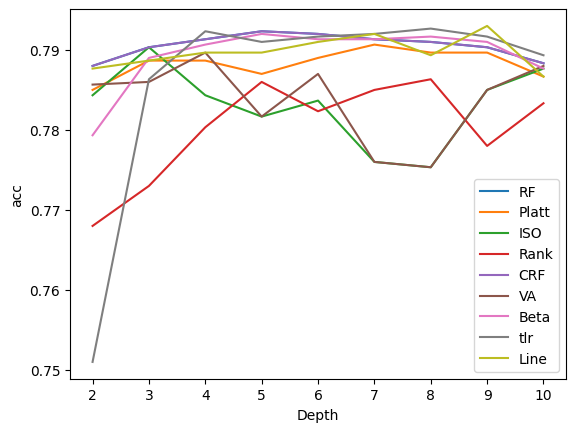

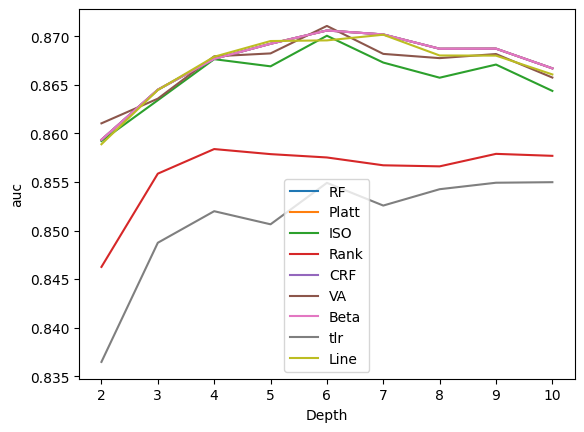

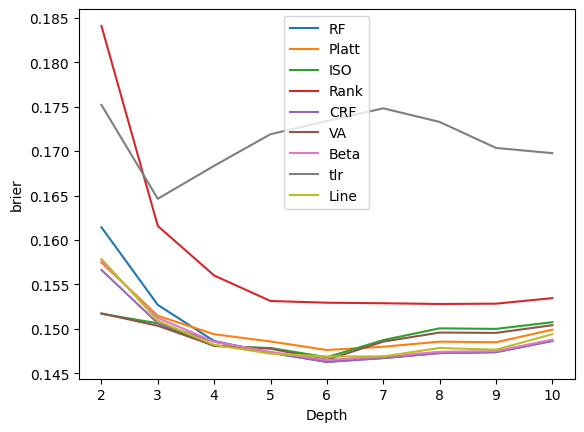

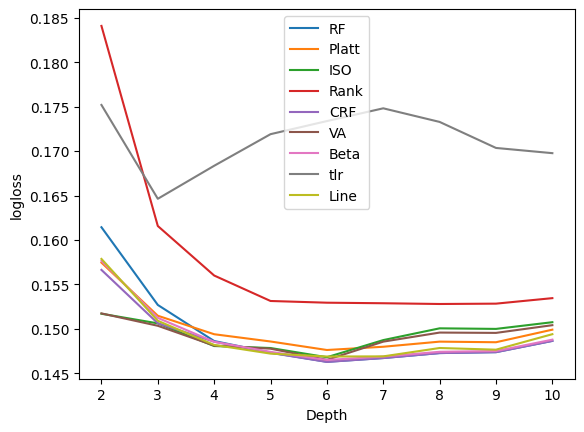

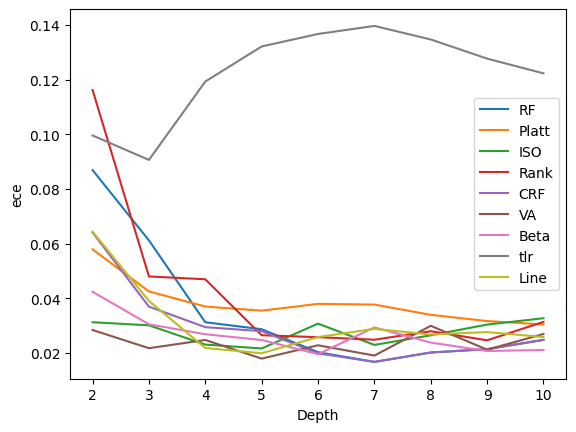

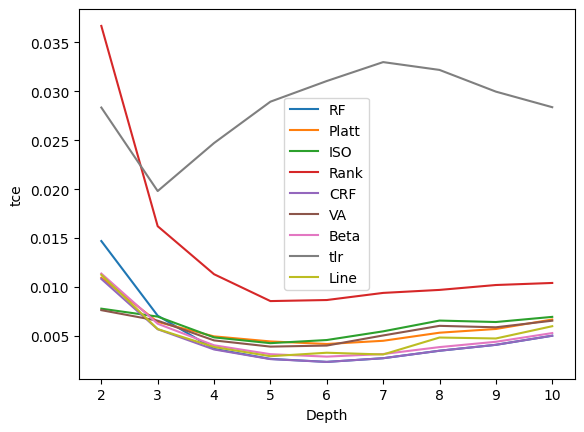

In [6]:
for metric in metrics:
    ax = tables[metric][plot_calib_methods].plot()
    ax.set_xlabel("Depth")
    ax.set_ylabel(metric)